There are three validation checks we need to do on each hand combination that was passed into the previous array in order to evaluate if it's a legitimate hand or not:

1.  The hand level sum needs to be lower than the max value for the hand and level
    - This is done by assigning each card in the combination it's level, so a level 1 card gets a 1, level 2 a 2, etc.
    - The sum of the array's level values then needs to be lower than the max value given by the following formula:
        - Max value formula = ((([1] + [Level])*[Level])/2) + ([Hand Size] - [Level])
        - Ex: For the Brute class, when evaluating hand combinations at level 2's selection time:
            - (((1+2)*2)/2) + (10-2)
            - 3 + 8 = 11
        - Intuitively, this makes sense as at level 1, the Brute class would have 10 level 1 cards for a total of 10
        - At level 2, at most, you would select one level 2 card and replace a level 1 card with it
        - That would replace a 1 value with a 2, taking the max value possible up to 11
        - If we ever run into a class that has a hand size lower than 8, this formula will need to be tweaked
            - This is because at a hand size of 8, you could remove a level 1 card for each level up
            - At a hand size of 7 or lower, the top level ups would mean you need to replace a card value over 1
        
2. At the level being evaluated, each hand combination can only have one of the level cards
    - When leveling up, you can initially only select a single card for the given level
    - This will filter out any combinations that load in something like two level 2 cards when evaluating level 2
    
3. The amount of cards over level 1 in the hand cannot exceed then evaluation level minus 1
    - This is because you can only make one card selection every time you level up
    - It is allowed for you to take a card lower than the level you're on, for example taking the 2nd lvl 2 card at level 3's promotion rather than a level 3
    - You cannot though have something like both level 2 cards AND a level 3 card at level 3
    - As the levels get higher, there are ways to make summation combinations that fall meet conditions 1 and 2 but use more cards > level 1 than is permitted

In [70]:
# Importing packages
import numpy as np
import pandas as pd
import itertools
import statistics as stat
import time
import matplotlib.pyplot as plt

In [2]:
# Loading in CSV data.  For now, this only contains a single class' cards and initiatives
rawdata = pd.read_csv("GloomhavenTest.csv")
gen_classinfo = pd.read_csv("ClassInfo.csv")

In [3]:
# Creating a max value function that will evaluate the value for condition 1 above
def maxvalue(handsize, current_level):
    return (((1 + current_level)*current_level)/2) + (handsize - current_level)

# Creating a function to count the number of cards at a level in a list
def lvl_counter(input_list, value):
    return sum([1 for v in input_list if v == value])

In [49]:
# Setting data items for use later in code
active_class = gen_classinfo['Class'][0]       # Setting the active class (Class[0] = Brute)
hand_size = gen_classinfo['Hand Size'][0]      # Setting the hand size

# Creating dictionaries to hold results
count_result_dict = dict()
avg_result_dict = dict()
stdev_result_dict = dict()

In [50]:
# %%timeit

for i in set(rawdata['Level']):
    
    # Setting the level and initiative columns for values up to the current level
    current_level = i   # Current level for the loop (envisioning this as a 1 -> 9 loop later)
    level_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Level']
    initiative_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Initiative']
    currlvl_df = pd.concat([level_df, initiative_df], axis = 1)


    # Second swing at a different roll-up method, using evaluations steps while looping the comb. iterator
    max_value = maxvalue(hand_size, current_level)  # Setting the max value for this class/level
    curr_lvl_minus1 = (current_level - 1)

    # Creating a dictionary to assign a binary 1 or 0 to each combination, based on it passing the hand conditions
    level_comb2 = dict()
    dict_counter = 0

    for hand in itertools.combinations(currlvl_df['Level'], hand_size):
        if sum(hand) <= max_value and \
        (hand_size - lvl_counter(hand,1)) <= curr_lvl_minus1 and (lvl_counter(hand, current_level)) != 2:
            level_comb2[dict_counter] = True
        else:
            level_comb2[dict_counter] = False 
        dict_counter += 1


    # Now creating a dictionary to reference the above binary dictionary in order to populate hand averages for valid hands
    initiative_comb2 = dict()
    dict_counter = 0
    valid_dict_counter = 0

    for hand in itertools.combinations(currlvl_df['Initiative'], hand_size):
        if level_comb2[dict_counter]:
            initiative_comb2[valid_dict_counter] = (sum(hand)/hand_size)
            valid_dict_counter += 1
        dict_counter += 1

    initiative_comb2_df = pd.DataFrame.from_dict(initiative_comb2, orient = 'Index')
    
    # Writing results
    count_result_dict[i - 1] = len(initiative_comb2_df)
    avg_result_dict[i - 1] = initiative_comb2_df.mean()
    stdev_result_dict[i - 1] = initiative_comb2_df.std()

In [69]:
count_results_df = pd.DataFrame.from_dict(count_result_dict, orient = 'Index')
avg_results_df = pd.DataFrame.from_dict(avg_result_dict, orient = 'Index')
stdev_results_df = pd.DataFrame.from_dict(stdev_result_dict, orient = 'Index')

total_results_df = pd.concat([count_results_df, avg_results_df, stdev_results_df], axis = 1)

print(total_results_df)

          0          0         0
0       286  44.000000  3.995919
1      1716  43.416667  4.326364
2      9581  43.502985  4.564459
3     46618  44.301534  5.266695
4    200343  43.646467  5.377058
5    744458  43.036881  5.583827
6   2405689  42.133240  5.542226
7   6806371  41.007196  5.616149
8  17178772  41.295620  5.679533


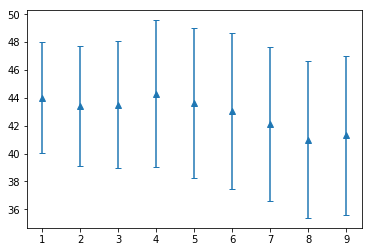

In [79]:
# x = set(rawdata['Level'])
# y = avg_results_df
# e = stdev_results_df

x = np.array([1,2,3,4,5,6,7,8,9])
y = np.array([44.00, 43.42, 43.50, 44.30, 43.64, 43.04, 42.13, 41.00, 41.30])
e = np.array([3.99, 4.33, 4.56, 5.27, 5.38, 5.58, 5.54, 5.62, 5.68])

plt.errorbar(x, y, e, linestyle='None', marker='^', capsize=3)

plt.show()